In [100]:
# Predicting Taxi out Delay using a Linear Regression Model

In [101]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics



In [102]:
# importing the dataset
dataset = pd.read_csv('M1_final.csv')
dataset.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,DEST,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_M,...,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Condition,sch_dep,sch_arr,TAXI_OUT
0,11,1,5,B6,N828JB,CHS,-1,124,636,324,...,34,58,W,25,38,29.86,Fair / Windy,9,17,14
1,11,1,5,B6,N992JB,LAX,-7,371,2475,340,...,34,58,W,25,38,29.86,Fair / Windy,9,17,15
2,11,1,5,B6,N959JB,FLL,40,181,1069,301,...,34,58,W,25,38,29.86,Fair / Windy,9,17,22
3,11,1,5,B6,N999JQ,MCO,-2,168,944,345,...,34,58,W,25,38,29.86,Fair / Windy,9,17,12
4,11,1,5,DL,N880DN,ATL,-4,139,760,360,...,32,58,W,24,35,29.91,Fair / Windy,9,17,13


# Project Description
Attempt to predict the taxi-out column based on the information in this dataset. 

Taxi-out is defined as the time the aircraft is spent moving from the terminal to taking off. 

After reviewing the columns above it appears that the columns that may effect the taxi-out time are the weather columns, so I will be using these in my predition model. These include:

- Temperature
- Dew Point
- Humidity
- Wind (direction)
- Wind Speed
- Wind Gust
- Pressure

In [103]:
# remove all other columns from the dataset
dataset = dataset[['Temperature','Dew Point','Humidity','Wind', 'Wind Speed', 'Wind Gust','Pressure','TAXI_OUT']]
dataset.head()

,Temperature,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,TAXI_OUT
0,48,34,58,W,25,38,29.86,14
1,48,34,58,W,25,38,29.86,15
2,48,34,58,W,25,38,29.86,22
3,48,34,58,W,25,38,29.86,12
4,46,32,58,W,24,35,29.91,13


In [104]:
# check the data types of the columns
dataset.dtypes

Temperature      int64
Dew Point       object
Humidity         int64
Wind            object
Wind Speed       int64
Wind Gust        int64
Pressure       float64
TAXI_OUT         int64
dtype: object

# Analysing the 'Object' columns 
the intent is to convert everything to a numberical type so we can work with the data in our model

#### 'Dew Point'

In [105]:
# show unique values for the Dew point column
dataset['Dew Point'].unique()

array(['34', '32', '33', '31', '30', '29', '67', '35', '36', '38', '39',
       '40', '41', '42', '28', '27', '46', '37', '44', '45', '52', '53',
       '54', '56', '57', '59', '58', '50', '43', '48', '49', '47', '21',
       '20', '22', '24', '23', '19', '18', '16', '13', '12', '14', '15',
       '17', '26', '25', '51', '55', '6\xa0', '9\xa0', '5\xa0', '8\xa0',
       '10', '4\xa0', '7\xa0', '3\xa0', '2\xa0', '11', '0\xa0', '-1',
       '1\xa0', '-2', '-3'], dtype=object)

The Dew Point column contains unicode which explains why its being called an object and not an int64

In [106]:
# remove the unicode characters from the Dew Point column
dataset['Dew Point'] = dataset['Dew Point'].str.replace(u'\xa0', u'')

# the data is clean
dataset['Dew Point'].unique()

array(['34', '32', '33', '31', '30', '29', '67', '35', '36', '38', '39',
       '40', '41', '42', '28', '27', '46', '37', '44', '45', '52', '53',
       '54', '56', '57', '59', '58', '50', '43', '48', '49', '47', '21',
       '20', '22', '24', '23', '19', '18', '16', '13', '12', '14', '15',
       '17', '26', '25', '51', '55', '6', '9', '5', '8', '10', '4', '7',
       '3', '2', '11', '0', '-1', '1', '-2', '-3'], dtype=object)

#### 'Wind'

In [107]:
# show unique values for the Wind column
dataset['Wind'].unique()

array(['W', 'WNW', 'NW', 'NNW', 'S', 'ENE', 'NE', 'NNE', 'E', 'SE',
       'CALM', 'SW', 'VAR', 'SSE', 'SSW', 'WSW', 'N', 'ESE', nan],
      dtype=object)

The wind column is showing us the cardinal direction of the wind where SSW = South, South, West for example.
I can convert these into degrees. 
I also see:
- CALM : the direction is perhaps to calm to identify lets make these nan as well
- VAR : this could mean variable meaning it changes direction lets make these nan
- nan : nan could mean there is no wind or there is no wind data

In [108]:
# convert the wind column items to degrees using the dictionary
wind_dict = {'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5, 'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5, 'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5, 'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5, 'CALM': np.nan, 'VAR': np.nan}
dataset['Wind'] = dataset['Wind'].map(wind_dict)

# show unique values for the Wind column
dataset['Wind'].unique()


array([270. , 292.5, 315. , 337.5, 180. ,  67.5,  45. ,  22.5,  90. ,
       135. ,   nan, 225. , 157.5, 202.5, 247.5,   0. , 112.5])

In [109]:
# check for missing values
dataset.isnull().sum()

Temperature       0
Dew Point         0
Humidity          0
Wind           1132
Wind Speed        0
Wind Gust         0
Pressure          0
TAXI_OUT          0
dtype: int64

I need to replace the nan values with eithor the mean or the median of the wind column. Lets find out which my viewing the histogram. 

<AxesSubplot: >

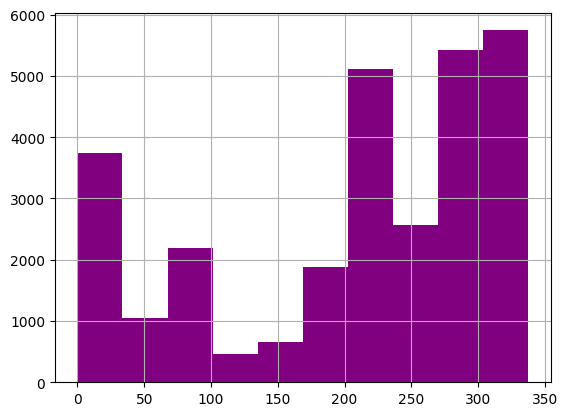

In [131]:
# hitsogramn of the wind column
dataset['Wind'].hist(color='purple')
# change the color of the histogram


the wind histogram has a skewed distribution so lets replace the nan values with the median

In [111]:
# replace the nan values in the wind column with the median
dataset['Wind'].fillna(dataset['Wind'].median(), inplace=True)

dataset.isnull().sum()


Temperature    0
Dew Point      0
Humidity       0
Wind           0
Wind Speed     0
Wind Gust      0
Pressure       0
TAXI_OUT       0
dtype: int64

In [112]:
# show unique values for the Wind column
dataset['Wind'].unique()

array([270. , 292.5, 315. , 337.5, 180. ,  67.5,  45. ,  22.5,  90. ,
       135. , 225. , 157.5, 202.5, 247.5,   0. , 112.5])

In [113]:
# check the data types of the columns
dataset.dtypes

Temperature      int64
Dew Point       object
Humidity         int64
Wind           float64
Wind Speed       int64
Wind Gust        int64
Pressure       float64
TAXI_OUT         int64
dtype: object

There are no more nan values in the wind column and all other values appear to be floats.
The wind column has now automatically updated to a float64. 
Lets convert the Dew Point Column and then we are good to go. 

In [114]:
# convert the dew point column to float64
dataset['Dew Point'] = dataset['Dew Point'].astype('float64')

# check the data types of the columns
dataset.dtypes

Temperature      int64
Dew Point      float64
Humidity         int64
Wind           float64
Wind Speed       int64
Wind Gust        int64
Pressure       float64
TAXI_OUT         int64
dtype: object

# Linear Regression Model

In [115]:
dataset.head()

,Temperature,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,TAXI_OUT
0,48,34.0,58,270.0,25,38,29.86,14
1,48,34.0,58,270.0,25,38,29.86,15
2,48,34.0,58,270.0,25,38,29.86,22
3,48,34.0,58,270.0,25,38,29.86,12
4,46,32.0,58,270.0,24,35,29.91,13


In [116]:
# split the dataset into the dependent and independent variables

# all the columns that are measuring weather data will be the independent variables
X = dataset.iloc[:, :-1].values
# the taxi out delay will be the dependent variable
y = dataset.iloc[:, -1].values

# split the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# create the linear regression model
regressor = LinearRegression()
# fit the model to the training set
regressor.fit(X_train, y_train)

# predict the test set results
y_pred = regressor.predict(X_test)

# compare the predicted values to the actual values
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df



,Actual,Predicted
0,17,20.753391
1,14,19.694409
2,12,21.603933
3,18,19.207866
4,18,20.592499
...,...,...
5759,17,20.440020
5760,13,17.601435
5761,20,18.319363
5762,35,20.588302


In [117]:
# evaluate the models accuracy
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred)) 
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))



Mean Absolute Error: 5.437283133148479
Mean Squared Error: 45.7846115479743
Root Mean Squared Error: 6.766432704754722


In [118]:
# check the accuracy score of the model
regressor.score(X_test, y_test)




0.031760510921386986

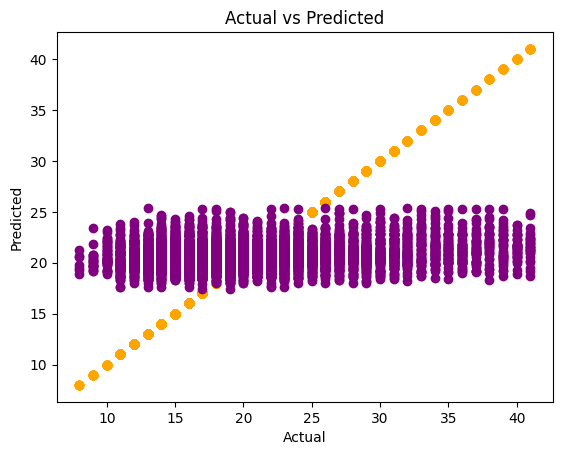

In [125]:
# plot the actual and predicted values

# plot the actual values
plt.scatter(y_test, y_test, color = 'orange')
# plot the predicted values
plt.scatter(y_test, y_pred, color = 'purple')
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()


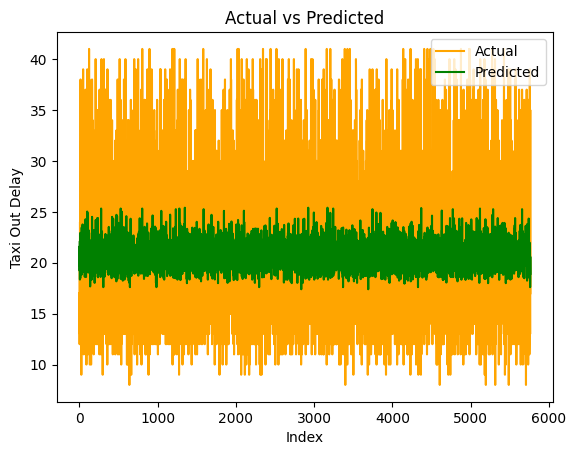

In [120]:
plt.plot(y_test, color = 'orange', label = 'Actual')
plt.plot(y_pred, color = 'purple', label = 'Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Taxi Out Delay')
plt.legend()
plt.show()
    

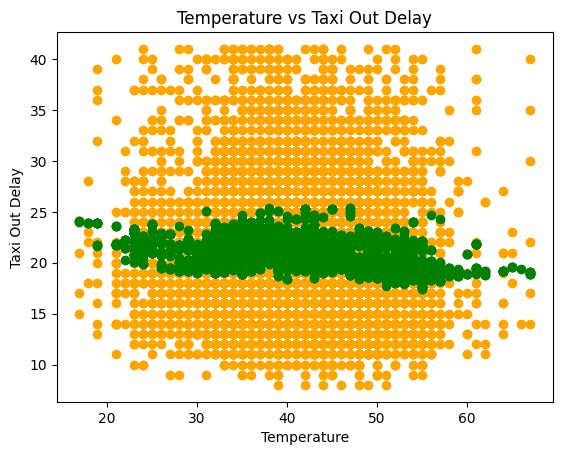

In [121]:
# plotting data and predicted variable for the temperature column

plt.scatter(X_test[:, 0], y_test, color = 'orange')
plt.scatter(X_test[:, 0], y_pred, color = 'purple')
plt.title('Temperature vs Taxi Out Delay')
plt.xlabel('Temperature')
plt.ylabel('Taxi Out Delay')
plt.show()



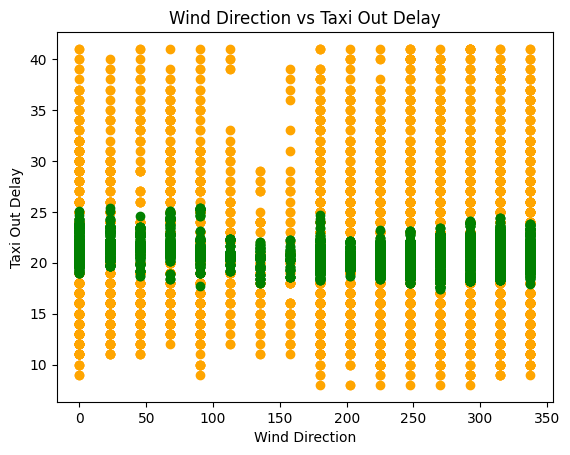

In [122]:
# plotting data and predicted variable for the wind direction
plt.scatter(X_test[:, 3], y_test, color = 'orange')
plt.scatter(X_test[:, 3], y_pred, color = 'purple')
plt.title('Wind Direction vs Taxi Out Delay')
plt.xlabel('Wind Direction')
plt.ylabel('Taxi Out Delay')
plt.show()

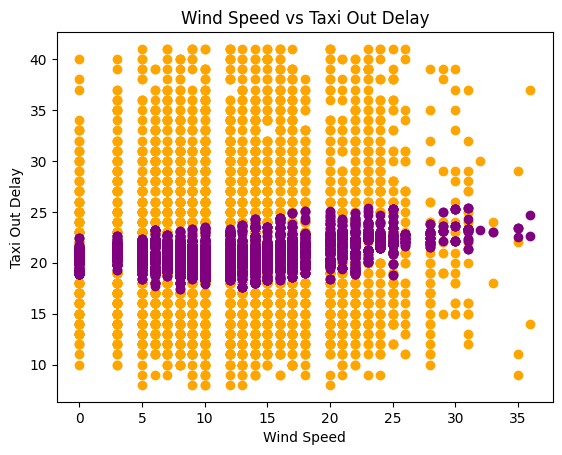

In [126]:
# plotting data and predicted variable for the wind speed
plt.scatter(X_test[:, 4], y_test, color = 'orange')
plt.scatter(X_test[:, 4], y_pred, color = 'purple')
plt.title('Wind Speed vs Taxi Out Delay')
plt.xlabel('Wind Speed')
plt.ylabel('Taxi Out Delay')
plt.show()